<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/1-word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word2Vec ## 

In this notebook we will go through the step by step creation of the Continouous Bag Of Words (CBOW).
CBOW is an embedded model that makes use of a "fake task" -> [within short window, predict the current word] to extract a vector that shows the relationship between words.

### Continuous Bag Of Words ###

Adapted from Robert Guthrie

In [78]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.linalg
from torch.utils.data import Dataset

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [80]:
# CBOW is a window view; we are trying to infer the word in the middle.
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

raw_text= """Long Short-Term Memory (LSTM) is a recurrent neural network (RNN) architecture that has been designed
to address the vanishing and exploding gradient problems of conventional RNNs. Unlike feedforward neural networks,
RNNs have cyclic connections making them powerful for modeling sequences. 
They have been successfully used for sequence labeling and sequence prediction tasks,
such as handwriting recognition, language modeling, phonetic labeling of acoustic frames. However, in contrast to the deep neural
networks, the use of RNNs in speech recognition has been limited to phone recognition in small scale tasks. 
In this paper, we present novel LSTM based RNN architectures which make more effective
use of model parameters to train acoustic models for large vocabulary speech recognition. 
We train and compare LSTM, RNN and DNN models at various numbers of parameters and configurations.
We show that LSTM models converge quickly and give state of the art speech recognition performance for relatively small sized models.""".split()

# By deriving a set from "raw_text", we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

# Basic Tokenizer
word_to_ix = {word: i for i, word in enumerate(vocab)}

print(len(raw_text))
print(vocab_size)

152
106


In [81]:
print(vocab)

{'relatively', '(RNN)', 'LSTM,', 'contrast', 'make', 'networks,', 'to', 'exploding', 'Short-Term', 'address', 'tasks,', 'feedforward', 'neural', 'and', 'prediction', 'acoustic', 'cyclic', 'sequence', 'art', 'state', 'vanishing', 'small', 'phonetic', 'use', 'Memory', 'present', 'them', 'designed', 'numbers', 'give', 'gradient', 'models', 'this', 'the', 'such', 'In', 'modeling', 'we', 'been', 'have', 'RNN', 'architecture', 'However,', 'LSTM', 'as', 'has', 'model', 'various', 'They', 'vocabulary', 'labeling', 'based', 'in', 'scale', 'paper,', 'quickly', 'show', 'performance', 'frames.', 'handwriting', 'Unlike', 'train', 'RNNs', 'Long', 'RNNs.', 'network', 'more', 'at', 'recurrent', 'conventional', 'problems', '(LSTM)', 'recognition,', 'sized', 'making', 'connections', 'speech', 'deep', 'which', 'a', 'phone', 'configurations.', 'language', 'recognition.', 'novel', 'DNN', 'We', 'architectures', 'sequences.', 'used', 'modeling,', 'compare', 'successfully', 'effective', 'models.', 'recognitio

In [82]:
# list out keys and values separately
key_list = list(word_to_ix.keys())
val_list = list(word_to_ix.values())

In [83]:
# Now lets create a "dataset"
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = []
    for j in range(CONTEXT_SIZE, 0, -1):
        context.append(raw_text[i - j])

    for j in range(1, CONTEXT_SIZE + 1):
        context.append(raw_text[i + j])
        
    target = raw_text[i]
    data.append((context, target))
print(data[:5])


[(['Long', 'Short-Term', '(LSTM)', 'is'], 'Memory'), (['Short-Term', 'Memory', 'is', 'a'], '(LSTM)'), (['Memory', '(LSTM)', 'a', 'recurrent'], 'is'), (['(LSTM)', 'is', 'recurrent', 'neural'], 'a'), (['is', 'a', 'neural', 'network'], 'recurrent')]


### Create the CBOW Model (as we have seen already other ANN) ###

We have to extend from nn.Module as all the other ANN

In [84]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_dim, context, hidden_size):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(context*embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
            nn.LogSoftmax(dim = -1)
        )
        
    def forward(self, inputs):
#         print(inputs.shape)
#         print(inputs)
        out = self.embedding(inputs)
#         print(out.shape)
        out = out.view(1, -1)
#         print(out.shape)
        out = self.linear(out)
#         print(out.shape)
        return out
    
    # This is what we are actually interested on
    def get_word_vector(self, word):
        out = self.embedding(word)
        return out


#### Lets break it down! ####

In [85]:
VOCAB_SIZE = len(vocab)
EMBEDD_DIM = 10
BATCH_SIZE = 6
FULL_CONTEXT_SIZE = CONTEXT_SIZE * 2
HIDDEN_SIZE = 256

example_tensor = torch.randint(0, VOCAB_SIZE, [BATCH_SIZE, FULL_CONTEXT_SIZE])
print(example_tensor)

tensor([[ 25,  75,   5,  85],
        [ 55,  16,  41,  26],
        [ 10,  23,  33,  63],
        [ 72,  65,  68,   6],
        [ 92,  11,  11, 105],
        [ 46,  72,  88,  85]])


In [86]:
CBOW_embedding = nn.Embedding(VOCAB_SIZE, EMBEDD_DIM)
print(example_tensor.shape)
example_result = CBOW_embedding(example_tensor)
# Now we have a representation of the words in a vector of EMBEDD_DIM Dimensions
print(example_result.shape)
# example_result = torch.flatten(example_result, start_dim=1)
example_result = example_result.view(BATCH_SIZE, -1)
print(example_result.shape)

torch.Size([6, 4])
torch.Size([6, 4, 10])
torch.Size([6, 40])


In [87]:
print("input shape: ", EMBEDD_DIM * FULL_CONTEXT_SIZE)
print("output shape: ", HIDDEN_SIZE)
CBOW_hidden = nn.Linear(EMBEDD_DIM * FULL_CONTEXT_SIZE, HIDDEN_SIZE)
CBOW_hidden_relu = nn.ReLU()
example_result = CBOW_hidden(example_result)
example_result = CBOW_hidden_relu(example_result)
print(example_result.shape)

input shape:  40
output shape:  256
torch.Size([6, 256])


In [88]:
CBOW_output = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)
CBOW_output_soft = nn.LogSoftmax(dim = -1)
example_result = CBOW_output(example_result)
example_result = CBOW_output_soft(example_result)
print(example_result.shape)

torch.Size([6, 106])


In [89]:
print(example_result[0].argmax(-1))
print(key_list[val_list.index(example_result[0].argmax(-1))])
print(example_result[0])
print(example_result[1].argmax(-1))
print(key_list[val_list.index(example_result[1].argmax(-1))])
print(example_result[1])
# print(example_result[2].argmax(-1))
# print(example_result[3].argmax(-1))
# print(example_result[4].argmax(-1))

tensor(58)
frames.
tensor([-4.7904, -4.9623, -4.8601, -5.1904, -4.6300, -4.7509, -4.5193, -4.8642,
        -4.8321, -4.4927, -4.3281, -4.6755, -4.2918, -4.4394, -5.0899, -4.6084,
        -4.6040, -5.1246, -4.5776, -4.9648, -4.6630, -4.7404, -4.9661, -4.2213,
        -4.8490, -4.3572, -5.1462, -4.7184, -5.1224, -4.5360, -4.4229, -4.7825,
        -4.3679, -4.6887, -4.7410, -4.8690, -4.2376, -5.1673, -5.0420, -5.0756,
        -4.6328, -4.4968, -4.8813, -4.5596, -4.3917, -4.5866, -4.3565, -4.8124,
        -4.6041, -4.3848, -4.5366, -4.6897, -4.3508, -4.9675, -4.9061, -4.5324,
        -4.8978, -4.9035, -4.2116, -4.7073, -4.6588, -4.9496, -4.6745, -4.6645,
        -4.6065, -4.6958, -4.6386, -4.9466, -4.7559, -4.6854, -4.4659, -4.6846,
        -4.5233, -4.9936, -4.4839, -4.4381, -4.7071, -4.3727, -4.8521, -4.7736,
        -4.5955, -4.2550, -4.9189, -4.8879, -4.8528, -4.9678, -4.3725, -5.0227,
        -4.4551, -4.2274, -5.0532, -4.5207, -4.9703, -5.0863, -4.9366, -4.6451,
        -4.8281, -4.3

## Back to the notebook ##

In [90]:
# Simple helper method to transform the context to the expected int vector - tensor

def make_context_vector(context, word_to_ix, debug=False):
    if debug:
      print(context)
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

make_context_vector(data[0][0], word_to_ix, debug=True)

['Long', 'Short-Term', '(LSTM)', 'is']


tensor([ 63,   8,  71, 104])

In [91]:
def train(model, epochs, data, optimizer, loss_fn):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for context, target in data:

            # Prepare inputs and targets 
            context_idxs = make_context_vector(context, word_to_ix)
            context_idxs = context_idxs.to(device)
            target_id = make_context_vector([target], word_to_ix)
            target_id = target_id.to(device)

            # Do not accumulate 
            model.zero_grad()

            # Step 3. Run the forward pass
            log_probs = model(context_idxs)
    #         break

            # Step 4. Compute your loss function.
            loss = loss_fn(log_probs, target_id)

    #         loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()
        losses.append(total_loss)
    return losses
    

In [92]:
VOCAB_SIZE = len(vocab)
EMBEDD_DIM = 10
BATCH_SIZE = 6
FULL_CONTEXT_SIZE = CONTEXT_SIZE * 2
HIDDEN_SIZE = 256

loss_function = nn.NLLLoss() # Because we are using Log_softmax
model = CBOW(vocab_size, EMBEDD_DIM, FULL_CONTEXT_SIZE, HIDDEN_SIZE)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

losses = train(model, 100, data, optimizer, loss_function)
model.eval()

print(losses)  # The loss decreased every iteration over the training data!

[692.3045339584351, 685.5489101409912, 678.8828220367432, 672.3038556575775, 665.807000875473, 659.3873643875122, 653.0399134159088, 646.7612862586975, 640.5472657680511, 634.3922827243805, 628.2911922931671, 622.2394349575043, 616.2339215278625, 610.2701280117035, 604.3468234539032, 598.4577651023865, 592.6002333164215, 586.7686891555786, 580.9634265899658, 575.1786081790924, 569.4103569984436, 563.6570386886597, 557.9125032424927, 552.1772928237915, 546.4465298652649, 540.7198725938797, 534.9940067529678, 529.2693037986755, 523.5428122282028, 517.8122780323029, 512.0757156610489, 506.3318119049072, 500.5803918838501, 494.81841480731964, 489.04646933078766, 483.263862490654, 477.46940100193024, 471.66042375564575, 465.8385550379753, 460.0026510357857, 454.15261054039, 448.28880661726, 442.4123861193657, 436.525890648365, 430.62708443403244, 424.71779149770737, 418.80055075883865, 412.8737002015114, 406.9388852715492, 400.9985491037369, 395.05275523662567, 389.1062517762184, 383.155532

In [93]:
# list out keys and values separately
key_list = list(word_to_ix.keys())
val_list = list(word_to_ix.values())

In [94]:
def similarity_cbow(word_1, word_2):
    
    # test word similarity
    print(word_1)
    print(word_2)
    w1_id = torch.tensor(word_to_ix[word_1], dtype=torch.long)
    w2_id = torch.tensor(word_to_ix[word_2], dtype=torch.long)
    w1_id = w1_id.to(device)
    w2_id = w2_id.to(device)
    
    word_1_vec = model.get_word_vector(w1_id)
    word_2_vec = model.get_word_vector(w2_id)
    
    # The norm of a vector (1D-matrix) is the square root of the sum of all the squared values within the vector.
    print(math.sqrt(torch.square(word_1_vec).sum()))    
    print(torch.linalg.norm(word_1_vec))
    print(torch.linalg.norm(word_2_vec))
    print(word_1_vec.dot(word_2_vec))
    
    word_distance = torch.linalg.norm(word_1_vec - word_2_vec)
    print("Distance between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_distance))
    word_similarity = (word_1_vec.dot(word_2_vec) / (torch.linalg.norm(word_1_vec) * torch.linalg.norm(word_2_vec)))
    print("Similarity between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_similarity))


In [95]:
similarity_cbow("neural", "network")

neural
network
3.8959419656931273
tensor(3.8959, grad_fn=<LinalgVectorNormBackward0>)
tensor(2.5683, grad_fn=<LinalgVectorNormBackward0>)
tensor(0.4146, grad_fn=<DotBackward0>)
Distance between 'neural' & 'network' : 4.5766
Similarity between 'neural' & 'network' : 0.0414


In [96]:
def predict_middle_word(prev_words, post_words):
    prev_words = prev_words.split()
    post_words = post_words.split()

    input_words= make_context_vector(prev_words + post_words, word_to_ix)
    input_words = input_words.to(device)
    output = model(input_words)
    out_ind = output.argmax(1)
#     print(word_to_ix)
#     out_word = word_to_ix.itos[out_ind.item()]
    out_word = key_list[val_list.index(out_ind.item())]
    print(prev_words, out_word, post_words)

In [97]:
predict_middle_word("a recurrent", "network is")
predict_middle_word("LSTM is", "recurrent neural")

['a', 'recurrent'] neural ['network', 'is']
['LSTM', 'is'] a ['recurrent', 'neural']


*Save this for future comparing*

In [98]:
cbow_embeddings = model.embedding.weight.data
print(cbow_embeddings)

tensor([[-0.3424, -0.5074, -1.0326,  ...,  1.1275,  2.9472, -0.2146],
        [-0.2926, -1.4640,  0.0720,  ...,  1.5400, -0.9136,  0.4402],
        [-2.1111, -0.6827,  0.5243,  ...,  0.1888,  0.2806, -0.6460],
        ...,
        [-0.0227,  0.4306,  1.4740,  ...,  0.9786,  0.4381,  0.3125],
        [-1.9037, -2.0413,  0.4481,  ...,  1.5686, -0.1879,  0.0581],
        [ 0.5301, -0.2735, -0.1140,  ...,  0.6076,  0.1346,  0.6432]])


### Now that you saw how to create the CBOW model (word2vec), you should work on doing the "opposite" model, Skip-Gram ###

Skip-gram as you saw on the lectures, reverses the problem so you need to predict through the "fake task" the context of the input

In [99]:
import nltk
import torch
nltk.download('punkt')

# print(len(raw_text))
def tokenize(text):
    if isinstance(text, list):
        text = " ".join(text)
    return nltk.word_tokenize(text.lower())

def create_word_index(text):
    tokens = tokenize(text)
    vocab = sorted(set(tokens))
    word_index = {word: i for i, word in enumerate(vocab)}
    return word_index, vocab
    
def key_value_together(word_index):
    key_list = list(word_to_ix.keys())
    val_list = list(word_to_ix.values())
    return key_list, val_list

word_to_ix, vocab = create_word_index(raw_text)
k, v = key_value_together(word_to_ix)
#print(word_to_ix)
# print(vocab)
# print(v)
#print(k)

def token_to_id(tokens, word_index):
    token_ids = [word_index.get(token, word_index.get("<unk>", 0)) for token in tokens]
    return token_ids

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mdarifulamin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [100]:
def skipgram(data, word_index, skipgram_context_words):
    
    input_tensor, output_tensor = [], []
    for text in data:
        text = text.strip()
        tokens = tokenize(text.lower())

        token_ids = token_to_id(tokens, word_index)

        for ids in range(len(token_ids)-skipgram_context_words*2):
            sequence = token_ids[ids: (ids + skipgram_context_words * 2 + 1)]
            context = sequence.pop(skipgram_context_words)
            target = sequence

            # return target, context
            for output in target:
                output_tensor.append(output)
                input_tensor.append(context)
        
    target_tensor = torch.tensor(output_tensor, dtype=torch.long)
    context_tensor = torch.tensor(input_tensor, dtype=torch.long)
        
    return context_tensor, target_tensor

In [101]:
class SkipGram_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, hidden_size)
        self.output = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_words):
        x = self.embedding(input_words)
        x = self.linear(x)
        x = self.output(x)
        return x


In [102]:
class SkipGramFromFunctionDataset(Dataset):
    def __init__(self, text, word_index, context_size=2):
        context_tensor, target_tensor = skipgram([text], word_index, context_size)
        self.inputs = context_tensor
        self.targets = target_tensor

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    

In [103]:
def train(epochs, model, data_loader, optimizer, loss_function):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in data_loader:
            inputs, targets = inputs, targets
            output = model(inputs)
            loss = loss_function(output, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")
    return losses

In [104]:
raw_text = """Long Short-Term Memory (LSTM) is a recurrent neural network (RNN) architecture that has been designed
to address the vanishing and exploding gradient problems of conventional RNNs. Unlike feedforward neural networks,
RNNs have cyclic connections making them powerful for modeling sequences. 
They have been successfully used for sequence labeling and sequence prediction tasks,
such as handwriting recognition, language modeling, phonetic labeling of acoustic frames. However, in contrast to the deep neural
networks, the use of RNNs in speech recognition has been limited to phone recognition in small scale tasks. 
In this paper, we present novel LSTM based RNN architectures which make more effective
use of model parameters to train acoustic models for large vocabulary speech recognition. 
We train and compare LSTM, RNN and DNN models at various numbers of parameters and configurations.
We show that LSTM models converge quickly and give state of the art speech recognition performance for relatively small sized models."""

In [105]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

word_to_ix, vocab = create_word_index(raw_text)
dataset = SkipGramFromFunctionDataset(raw_text, word_to_ix, context_size=2)
data_loader = DataLoader(dataset, batch_size=6, shuffle=True)

VOCAB_SIZE = len(vocab)
EMBEDD_DIM = 10
HIDDEN_SIZE = 256

loss_function = nn.CrossEntropyLoss()
model = SkipGram_Model(VOCAB_SIZE, EMBEDD_DIM, HIDDEN_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)
losses = train(50, model, data_loader, optimizer, loss_function)

Epoch 1: Loss = 520.4598
Epoch 2: Loss = 518.0428
Epoch 3: Loss = 515.3783
Epoch 4: Loss = 513.0126
Epoch 5: Loss = 510.6827
Epoch 6: Loss = 508.3661
Epoch 7: Loss = 505.8381
Epoch 8: Loss = 503.9010
Epoch 9: Loss = 501.8000
Epoch 10: Loss = 499.7019
Epoch 11: Loss = 497.5215
Epoch 12: Loss = 495.7813
Epoch 13: Loss = 493.8320
Epoch 14: Loss = 492.2897
Epoch 15: Loss = 490.7152
Epoch 16: Loss = 488.6915
Epoch 17: Loss = 487.4025
Epoch 18: Loss = 485.0498
Epoch 19: Loss = 484.2510
Epoch 20: Loss = 482.3834
Epoch 21: Loss = 480.6982
Epoch 22: Loss = 479.7855
Epoch 23: Loss = 478.5559
Epoch 24: Loss = 477.1745
Epoch 25: Loss = 475.7754
Epoch 26: Loss = 474.6756
Epoch 27: Loss = 473.3072
Epoch 28: Loss = 472.2921
Epoch 29: Loss = 471.2237
Epoch 30: Loss = 470.4474
Epoch 31: Loss = 469.3731
Epoch 32: Loss = 468.2008
Epoch 33: Loss = 466.8861
Epoch 34: Loss = 465.6813
Epoch 35: Loss = 465.1063
Epoch 36: Loss = 464.3914
Epoch 37: Loss = 463.8863
Epoch 38: Loss = 462.2638
Epoch 39: Loss = 461.

In [106]:
def test_skipgram(model, word, word_to_ix, ix_to_word, top_k=5):
    model.eval()
    if word not in word_to_ix:
        print(f"'{word}' not in vocabulary.")
        return

    word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
    with torch.no_grad():
        output = model(word_idx)
        predicted_indices = torch.topk(output, top_k).indices.squeeze().tolist()

    print(f"\nGiven word: '{word}'")
    print("Predicted context words:")
    for idx in predicted_indices:
        print(f"  - {ix_to_word[idx]}")

In [107]:
ix_to_word = {idx: word for word, idx in word_to_ix.items()}
test_skipgram(model, "popular", word_to_ix, ix_to_word)

'popular' not in vocabulary.


In [108]:
skipgram_embeddings = model.embedding.weight.data
print(skipgram_embeddings)

tensor([[ 4.1484e-01, -1.6191e-01, -3.4068e-01,  9.5153e-01,  4.3752e-01,
         -4.8304e-01,  1.4677e-01, -1.1482e-01,  2.0242e+00, -1.6299e+00],
        [ 6.1028e-01,  2.6344e+00,  2.1352e-01, -2.6647e-01, -4.5279e-01,
         -8.7231e-01,  6.1436e-01, -1.4405e+00,  6.2329e-01,  6.1297e-01],
        [-1.8034e+00, -5.9418e-01, -1.0436e-01, -4.8830e-01,  1.3141e+00,
         -8.4413e-01, -1.4497e+00, -6.1204e-01, -3.8930e-01, -1.3495e+00],
        [-1.1139e+00,  2.1245e-01,  1.8824e+00,  7.7845e-01,  2.2217e-01,
         -4.0234e-01, -4.4679e-01, -8.7836e-01, -1.0687e+00, -3.1027e-01],
        [ 1.4160e+00, -6.7106e-01,  1.8834e-01,  2.8204e-01, -1.4444e+00,
         -8.0158e-01, -1.4209e+00, -1.4617e+00, -3.1821e-01,  1.5778e+00],
        [ 1.4203e+00, -1.6527e+00,  2.1364e+00,  5.8995e-01, -1.4614e+00,
          3.7093e-01,  5.2531e-01,  1.0391e+00, -1.7646e+00,  1.1379e+00],
        [ 1.3670e+00, -1.7678e-01,  3.9176e-01,  6.7659e-01, -5.8724e-01,
         -6.6393e-01, -1.0857e+0

Comparison between CBOW and Skipgram

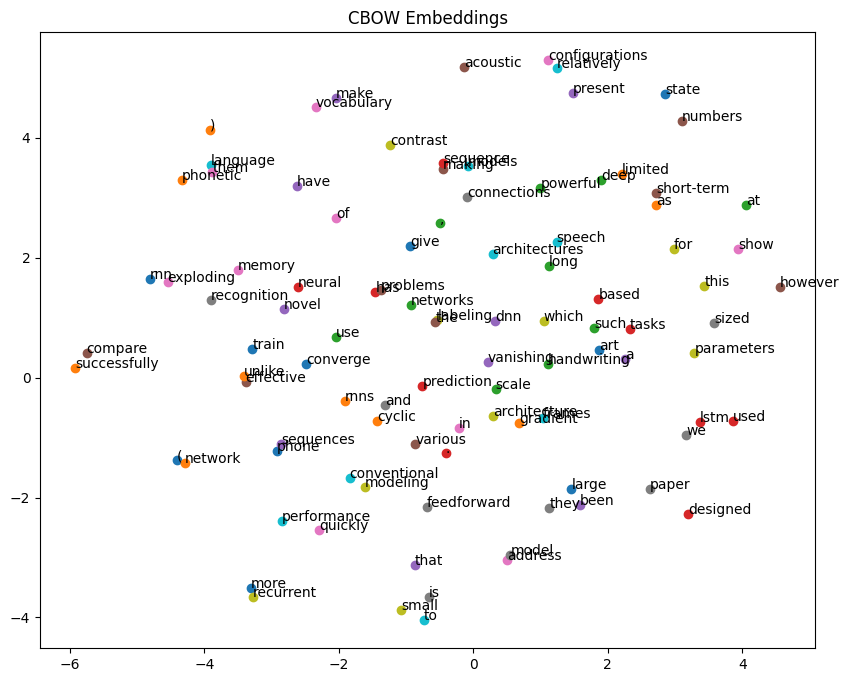

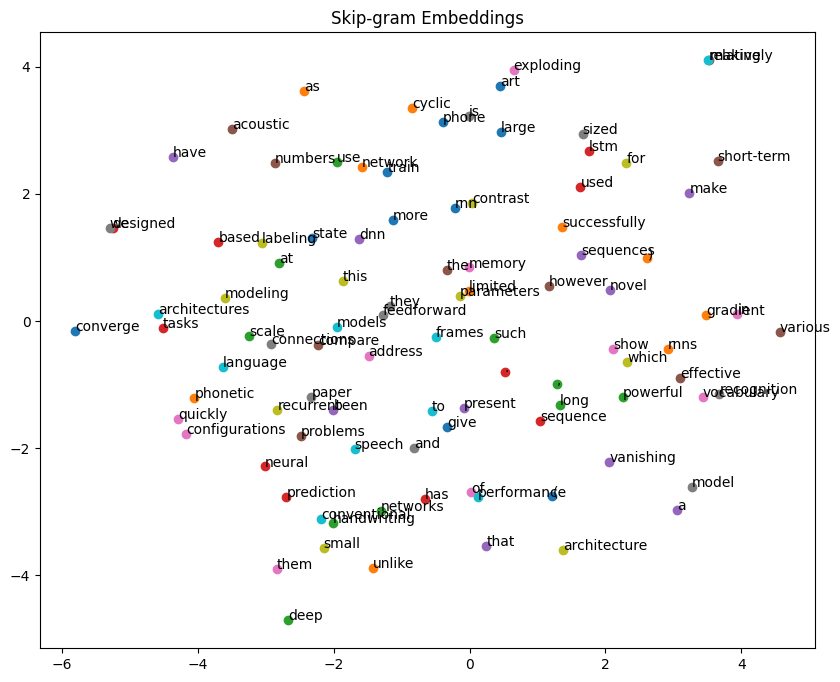

In [109]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.annotate(label, (x, y))
    plt.title(title)
    plt.show()
plot_embeddings(cbow_embeddings[:100].cpu(), vocab[:100], "CBOW Embeddings")
plot_embeddings(skipgram_embeddings[:100].cpu(), vocab[:100], "Skip-gram Embeddings")


In [112]:
from torch.nn.functional import cosine_similarity

def get_top_k_similar(word, embeddings, word_to_ix, k=5):
    idx = word_to_ix[word]
    target_embedding = embeddings[idx]
    similarities = cosine_similarity(target_embedding.unsqueeze(0), embeddings)
    topk = torch.topk(similarities, k+1)
    return [(list(word_to_ix.keys())[i], similarities[i].item()) for i in topk.indices[1:]]

# Compare neighbors
print("CBOW Neighbors:", get_top_k_similar("recognition", cbow_embeddings, word_to_ix))
print("Skip-gram Neighbors:", get_top_k_similar("recognition", skipgram_embeddings, word_to_ix))


CBOW Neighbors: [('memory', 0.7639314532279968), ('exploding', 0.7470322847366333), ('converge', 0.6875811815261841), ('(', 0.5984742045402527), ('rnn', 0.5898550152778625)]
Skip-gram Neighbors: [('effective', 0.7065288424491882), ('vocabulary', 0.6793138384819031), ('used', 0.6112534999847412), ('rnns', 0.594128429889679), ('for', 0.5845972895622253)]
